
# Max Colorable Induced Subgraph Problem



## Background

Given a graph $G = (V,E)$ and number of colors K, find the **largest induced subgraph that can be colored using up to K colors**.

A coloring is legal if:

- each vetrex ${v_i}$ is assigned with a color $k_i \in \{0, 1, ..., k-1\}$
- adajecnt vertex have different colors: for each $v_i, v_j$ such that $(v_i, v_j) \in E$, $k_i \neq k_j$.

An induced subgraph of a graph $G = (V,E)$ is a graph $G'=(V', E')$ such that $V'\subset V$ and $E' = \{(v_1, v_2) \in E\ |\ v_1, v_2 \in V'\}$.


### Necessary Packages

In this demo, besides the `classiq` package, we'll use the following packages:

In [1]:
%%capture
! pip install 'networkx[default]'
! pip install pyomo
! pip install matplotlib

## Define the optimization problem

In [2]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_max_k_colorable_model(graph, K):
    model = pyo.ConcreteModel()

    nodes = list(graph.nodes())
    colors = range(0, K)

    # each x_i states if node i belongs to the cliques
    model.x = pyo.Var(colors, nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    adjacency_matrix_block_diagonal = np.kron(np.eye(K), adjacency_matrix)

    # constraint that 2 nodes sharing an edge mustn't have the same color
    model.conflicting_color_constraint = pyo.Constraint(
        expr=x_variables @ adjacency_matrix_block_diagonal @ x_variables == 0
    )

    # each node should be colored
    @model.Constraint(nodes)
    def each_node_is_colored_once_or_zero(model, node):
        return sum(model.x[color, node] for color in colors) <= 1

    def is_node_colored(node):
        is_colored = np.prod([(1 - model.x[color, node]) for color in colors])
        return 1 - is_colored

    # maximize the number of nodes in the chosen clique
    model.value = pyo.Objective(
        expr=sum(is_node_colored(node) for node in nodes), sense=pyo.maximize
    )

    return model

### Initialize the model with parameters

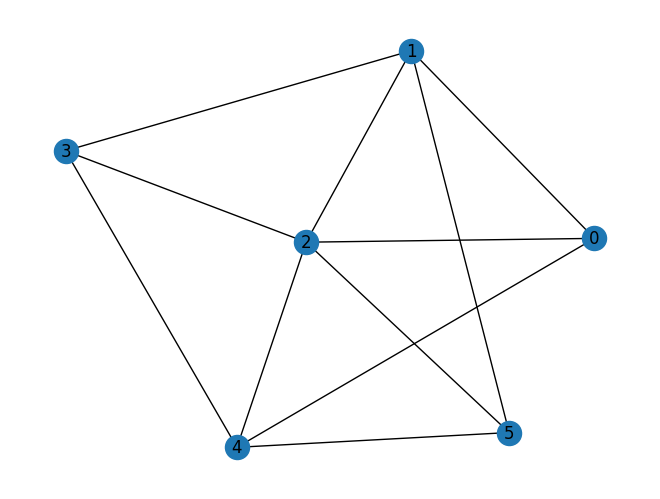

In [3]:
graph = nx.erdos_renyi_graph(6, 0.5, seed=7)
nx.draw_kamada_kawai(graph, with_labels=True)

NUM_COLORS = 2

coloring_model = define_max_k_colorable_model(graph, NUM_COLORS)

### print the resulting pyomo model

In [4]:
coloring_model.pprint()

4 Set Declarations
    each_node_is_colored_once_or_zero_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   12 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}

1 Var Declarations
    x : Size=12, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  T

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=8)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(max_iteration=20, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=coloring_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
from classiq import write_qmod

write_qmod(qmod, "max_induced_k_color_subgraph")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/0e473812-aa8b-43c0-8d2a-deba70289250?version=0.38.0.dev42%2Bfd36e2c41c


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

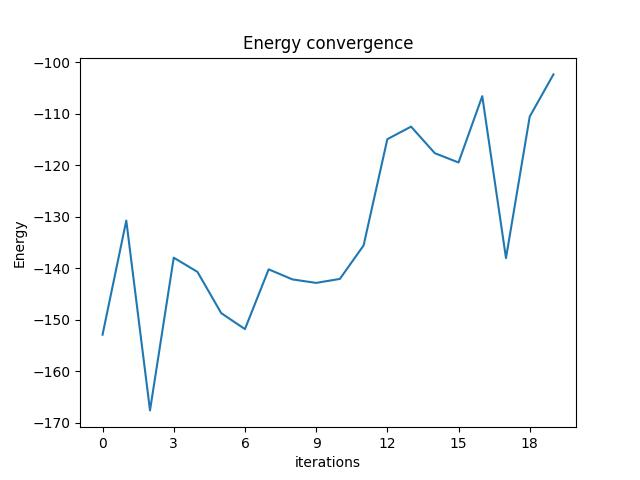

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    coloring_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
428,0.001,5.0,"[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]",1
59,0.002,4.0,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]",2
519,0.001,4.0,"[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]",1
555,0.001,4.0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]",1
668,0.001,4.0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

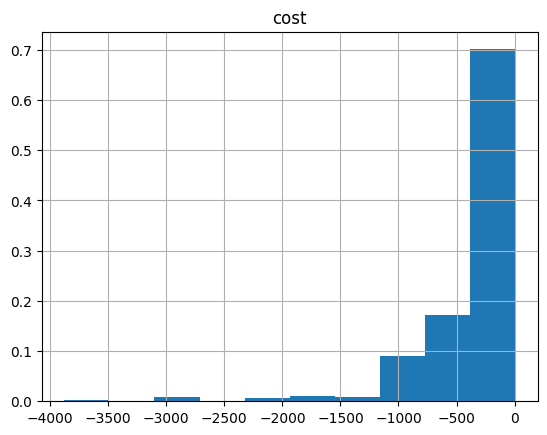

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the best solution:

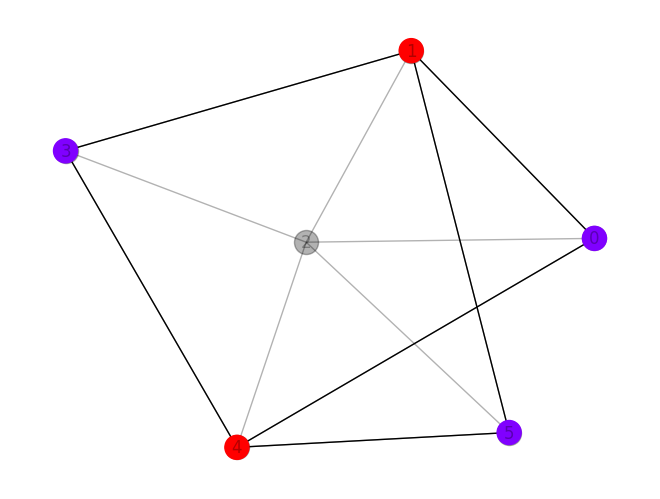

In [15]:
import matplotlib.pyplot as plt

best_solution = optimization_result.solution[optimization_result.cost.idxmax()]

one_hot_solution = np.array(best_solution).reshape([NUM_COLORS, len(graph.nodes)])
integer_solution = np.argmax(one_hot_solution, axis=0)

colored_nodes = np.array(graph.nodes)[one_hot_solution.sum(axis=0) != 0]
colors = integer_solution[colored_nodes]

pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos=pos, with_labels=True, alpha=0.3, node_color="k")
nx.draw(graph.subgraph(colored_nodes), pos=pos, node_color=colors, cmap=plt.cm.rainbow)

## Classical optimizer results

Lastly, we can compare to the classical solution of the problem:

In [16]:
from pyomo.common.errors import ApplicationError
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
result = None
try:
    result = solver.solve(coloring_model)
except ApplicationError:
    print("Solver might have not exited normally. Try again")

coloring_model.display()

ERROR: Solver (asl) returned non-zero return code (-6)


ERROR: Solver log: Couenne 0.5.8 -- an Open-Source solver for Mixed Integer
    Nonlinear Optimization Mailing list: couenne@list.coin-or.org
    Instructions: http://www.coin-or.org/Couenne malloc_consolidate(): invalid
    chunk size couenne:


Solver might have not exited normally. Try again
Model unknown

  Variables:
    x : Size=12, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 5) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary
        (1, 3) :     0 :  None :     1 : False :  True : Binary
        (1, 4) :     0 :  None :     1 : False :  True : Binary
        (1, 5) :     0 :  None :     1 : False :  True : Binary

  Objectives:
    value : Size=1, Index=None, Active=True
E

ERROR: evaluating object as numeric value: value
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object x[0,0]


        Key : Active : Value
        None :   None :  None

  Constraints:
    conflicting_color_constraint : Size=1
        Key  : Lower : Body : Upper
        None :   0.0 : None :   0.0
    each_node_is_colored_once_or_zero : Size=6
        Key : Lower : Body : Upper
          0 :  None : None :   1.0
          1 :  None : None :   1.0
          2 :  None : None :   1.0
          3 :  None : None :   1.0
          4 :  None : None :   1.0
          5 :  None : None :   1.0


In [17]:
if result:
    classical_solution = [
        pyo.value(coloring_model.x[i, j])
        for i in range(NUM_COLORS)
        for j in range(len(graph.nodes))
    ]
    one_hot_solution = np.array(classical_solution).reshape(
        [NUM_COLORS, len(graph.nodes)]
    )
    integer_solution = np.argmax(one_hot_solution, axis=0)

    colored_nodes = np.array(graph.nodes)[one_hot_solution.sum(axis=0) != 0]
    colors = integer_solution[colored_nodes]

    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos=pos, with_labels=True, alpha=0.3, node_color="k")
    nx.draw(
        graph.subgraph(colored_nodes), pos=pos, node_color=colors, cmap=plt.cm.rainbow
    )